<a href="https://colab.research.google.com/github/arvind-maurya/MachineLearning/blob/master/Consumer_Complain_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install chart-studio
from chart_studio import plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
import nltk
nltk.download('stopwords')
from nltk import word_tokenize
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!unzip /content/drive/MyDrive/ColabNotebooks/Dataset/consumer_complaints.zip -d /content/drive/MyDrive/ColabNotebooks/Dataset


Archive:  /content/drive/MyDrive/ColabNotebooks/Dataset/consumer_complaints.zip
  inflating: /content/drive/MyDrive/ColabNotebooks/Dataset/consumer_complaints.csv  


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ColabNotebooks/Dataset/consumer_complaints.csv')

<ipython-input-7-95444447f08d>:1: DtypeWarning:

Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.



In [ ]:
df.head()

,date_received,Product,sub_product,issue,sub_issue,Consumer complaint narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09-03-2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09-03-2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473
3,08/30/2013,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,08/30/2013,Closed with explanation,Yes,Yes,510326
4,08/30/2013,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,08/30/2013,Closed with explanation,Yes,Yes,511067


In [ ]:
df.rename(columns = {'Consumer complaint narrative':'Consumer_complaint_narrative'}, inplace = True)

In [ ]:
df = df[df.Consumer_complaint_narrative.notnull()]

In [ ]:
df.Product.value_counts()

Debt collection            17552
Mortgage                   14919
Credit reporting           12526
Credit card                 7929
Bank account or service     5711
Consumer Loan               3678
Student loan                2128
Prepaid card                 861
Payday loan                  726
Money transfers              666
Other financial service      110
Name: Product, dtype: int64

In [ ]:
df.Product

190126     Debt collection
190135       Consumer Loan
190155            Mortgage
190207            Mortgage
190208            Mortgage
                ...       
553084    Credit reporting
553085    Credit reporting
553086         Payday loan
553090            Mortgage
553096            Mortgage
Name: Product, Length: 66806, dtype: object

In [ ]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df = df[df.Product != 'Other financial service']

In [ ]:
import plotly.io as pio
pio.renderers.default = "colab"

In [ ]:
df['Product'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of Complaints',
                                                                title='Number complaints in each product')

In [ ]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):

    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['Consumer_complaint_narrative'] = df['Consumer_complaint_narrative'].apply(clean_text)

In [ ]:
df['Consumer_complaint_narrative']

0        claimed owe 2700 years despite proof payment s...
1        due inconsistencies amount owed told bank amou...
2        wages earned job decreased almost half knew tr...
3        open current mortgage chase bank # chase repor...
4        submitted time submitted complaint dealt rushm...
                               ...                        
66691    reporting incorrectly payments time vehicle tu...
66692             reflecting incorrect payment status time
66693    paying 18000 month direct debit withdrawal che...
66694    recently became aware amerisave mortgage corpo...
66695    bank america demonstrated ongoing level incomp...
Name: Consumer_complaint_narrative, Length: 66696, dtype: object

In [ ]:
df['Consumer_complaint_narrative'] = df['Consumer_complaint_narrative'].str.replace('\d+', '')

<ipython-input-18-ac2b9fba58d2>:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer_complaint_narrative'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 56726 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['Consumer_complaint_narrative'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (66696, 250)


In [ ]:
Y = pd.get_dummies(df['Product']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (66696, 10)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(60026, 250) (60026, 10)
(6670, 250) (6670, 10)


In [ ]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (Spatial  (None, 250, 100)          0         
 Dropout1D)                                                      
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 10)                1010      
                                                                 
Total params: 5081410 (19.38 MB)
Trainable params: 5081410 (19.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/5
845/845 [==============================] - 771s 906ms/step - loss: 1.1211 - accuracy: 0.6457 - val_loss: 0.8307 - val_accuracy: 0.7496
Epoch 2/5
845/845 [==============================] - 775s 916ms/step - loss: 0.8493 - accuracy: 0.7373 - val_loss: 0.7322 - val_accuracy: 0.7828
Epoch 3/5
845/845 [==============================] - 752s 890ms/step - loss: 0.6130 - accuracy: 0.8158 - val_loss: 0.6289 - val_accuracy: 0.8073
Epoch 4/5
845/845 [==============================] - 705s 834ms/step - loss: 0.5056 - accuracy: 0.8465 - val_loss: 0.5783 - val_accuracy: 0.8238
Epoch 5/5
845/845 [==============================] - 716s 848ms/step - loss: 0.4428 - accuracy: 0.8674 - val_loss: 0.5770 - val_accuracy: 0.8271


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

209/209 [==============================] - 30s 143ms/step - loss: 0.5724 - accuracy: 0.8337
Test set
  Loss: 0.572
  Accuracy: 0.834


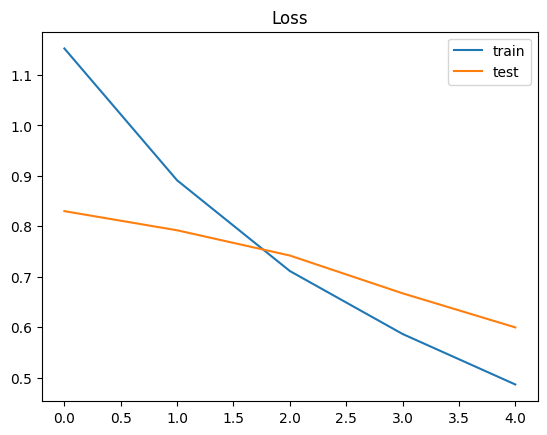

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();


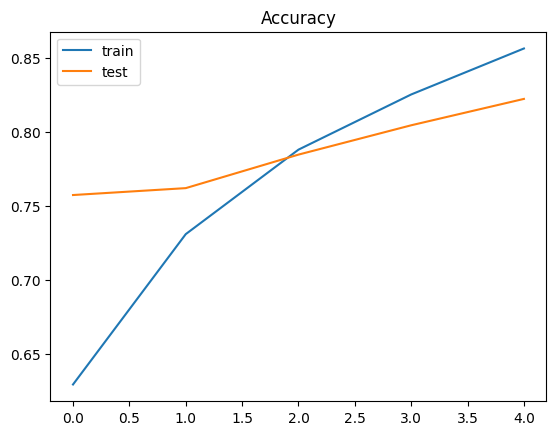

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Bank account or service', 'Consumer Loan', 'Credit card or prepaid card','Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Money transfers', 'Mortgage', 'Other financial service', 'Payday loan, title loan, or personal loan', 'Prepaid card', 'Student loan']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 62ms/step
[[3.5440844e-02 1.4905572e-02 6.9970560e-01 2.3170368e-01 1.0218543e-02
  1.9767719e-04 6.6765482e-03 8.7403409e-05 9.3462516e-04 1.2945948e-04]] Credit card or prepaid card


In [ ]:
new_complaint = ['I would like to take education loan for study pupose']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Bank account or service', 'Consumer Loan', 'Credit card or prepaid card','Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Money transfers', 'Mortgage', 'Payday loan, title loan, or personal loan', 'Prepaid card', 'Student loan']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 227ms/step
[[0.00444719 0.05676903 0.00081193 0.02500545 0.04844877 0.00499505
  0.00813666 0.05051678 0.00143049 0.7994387 ]] Student loan


# New Section

# New Section